In [11]:
library(readxl) ## Leer excel
library(tidyverse) ## Manipular base de datos
library(igraph) ## Grafos
library(expm) 
library(writexl)
library(ggraph)
library(tidygraph)  # para manipular grafos estilo tidy

In [12]:
# Lee un archivo Excel ubicado en la ruta especificada
# En este caso, se lee un archivo llamado "Matriz_de_Adyacencia_Pensiones_v5.xlsx"
# que se encuentra en el escritorio del usuario, dentro de una carpeta de tesis.

# Argumento:
# - col_names = TRUE: indica que la primera fila del archivo contiene los nombres de las columnas.

# Resultado:
# Se guarda el contenido del Excel en un data frame llamado `matriz`.

matriz <- read_excel(
    "C:/Users/cfutr/OneDrive/Escritorio/CICS/2025/Tesis/Objetivos de Aprendizaje/Modelo/Matriz/Matriz_de_Adyacencia_Pensiones_v5.xlsx", col_names=TRUE)

In [13]:
# Toma el data frame `matriz` (cargado desde un archivo Excel previamente)
# y lo transforma en una matriz de adyacencia numérica.

# Paso 1: column_to_rownames(var = colnames(.)[1])
#   - Convierte la primera columna (por ejemplo, "Concepto") en los nombres de las filas.
#   - Esto es útil si esa columna representa los nodos (conceptos) de la red.

# Paso 2: mutate(across(everything(), as.numeric))
#   - Aplica `as.numeric()` a todas las columnas del data frame.
#   - Esto asegura que todos los valores sean interpretados como números (por ejemplo, 0s y 1s),
#     y no como texto o factores. Es esencial para que la matriz sea válida como adyacencia.

# Paso 3: as.matrix()
#   - Convierte el data frame limpio en una matriz (tipo base de R).
#   - Esta matriz se puede usar directamente para crear grafos o realizar operaciones algebraicas.

# Resultado:
# `matriz_adj` es una matriz cuadrada con nombres de fila y columna, 
# representando las conexiones (adyacencias) entre conceptos en formato binario o numérico.

matriz_adj<-matriz%>%
  column_to_rownames(var = colnames(.)[1])%>%                         
  mutate(across(everything(), as.numeric)) %>%  
  as.matrix()

In [14]:
# Reemplaza todos los valores NA (valores perdidos) en la matriz de adyacencia `matriz_adj` por ceros.

# ¿Por qué es necesario?
# - Al convertir desde Excel, algunas celdas vacías pueden haberse interpretado como NA.
# - En una matriz de adyacencia, NA no tiene sentido lógico: se espera 1 (existe conexión) o 0 (no existe).
# - Esta línea asegura que todos los elementos no definidos explícitamente como conexiones se traten como "sin conexión" (0).

# Resultado:
# `matriz_adj` ahora es una matriz numérica limpia, sin valores faltantes,
# lista para ser usada en análisis de redes o visualizaciones (por ejemplo, con igraph o ggraph).

matriz_adj[is.na(matriz_adj)] <- 0

In [15]:
# Crea un grafo dirigido (objeto de clase `igraph`) a partir de la matriz de adyacencia `matriz_adj`.

# Argumentos:
# - matriz_adj: matriz cuadrada con valores numéricos (por ejemplo, 0 y 1),
#   donde cada celda [i, j] indica si existe una conexión desde el nodo i al nodo j "j necesita de i para ser comprendido" .
#
# - mode = "directed":
#   especifica que las conexiones representadas en la matriz son dirigidas,
#   es decir, que una arista desde A hacia B no implica necesariamente una desde B hacia A.

# Resultado:
# - `g` es un objeto de clase `igraph` que representa el grafo dirigido.
# - Puede ser usado para análisis de redes, visualización, extracción de componentes,
#   detección de caminos, ciclos, grados, etc.

# Nota:
# - Los nombres de los nodos serán tomados desde los nombres de fila/columna de `matriz_adj`, si están presentes.

g <- graph_from_adjacency_matrix(matriz_adj, mode = "directed")

In [16]:
# Suponiendo que tienes tu grafo dirigido
# g <- graph_from_adjacency_matrix(...)

# Convertimos a data.frame las aristas
aristas <- as_data_frame(g, what = "edges")

# Generamos un identificador de cada par como "A--B" ordenado alfabéticamente
aristas$pair_id <- apply(aristas[, c("from", "to")], 1, function(x) paste(sort(x), collapse = "--"))

# Contamos cuántas veces aparece cada par (si es 2, hay doble dirección)
dobles <- aristas %>%
  group_by(pair_id) %>%
  filter(n() == 2) %>%
  ungroup()

# Resultado: lista de aristas que forman relaciones bidireccionales
dobles

from,to,pair_id
<chr>,<chr>,<chr>


In [17]:
pares_bidireccionales <- unique(dobles$pair_id)
pares_bidireccionales%>%as.data.frame() 

.
<chr>


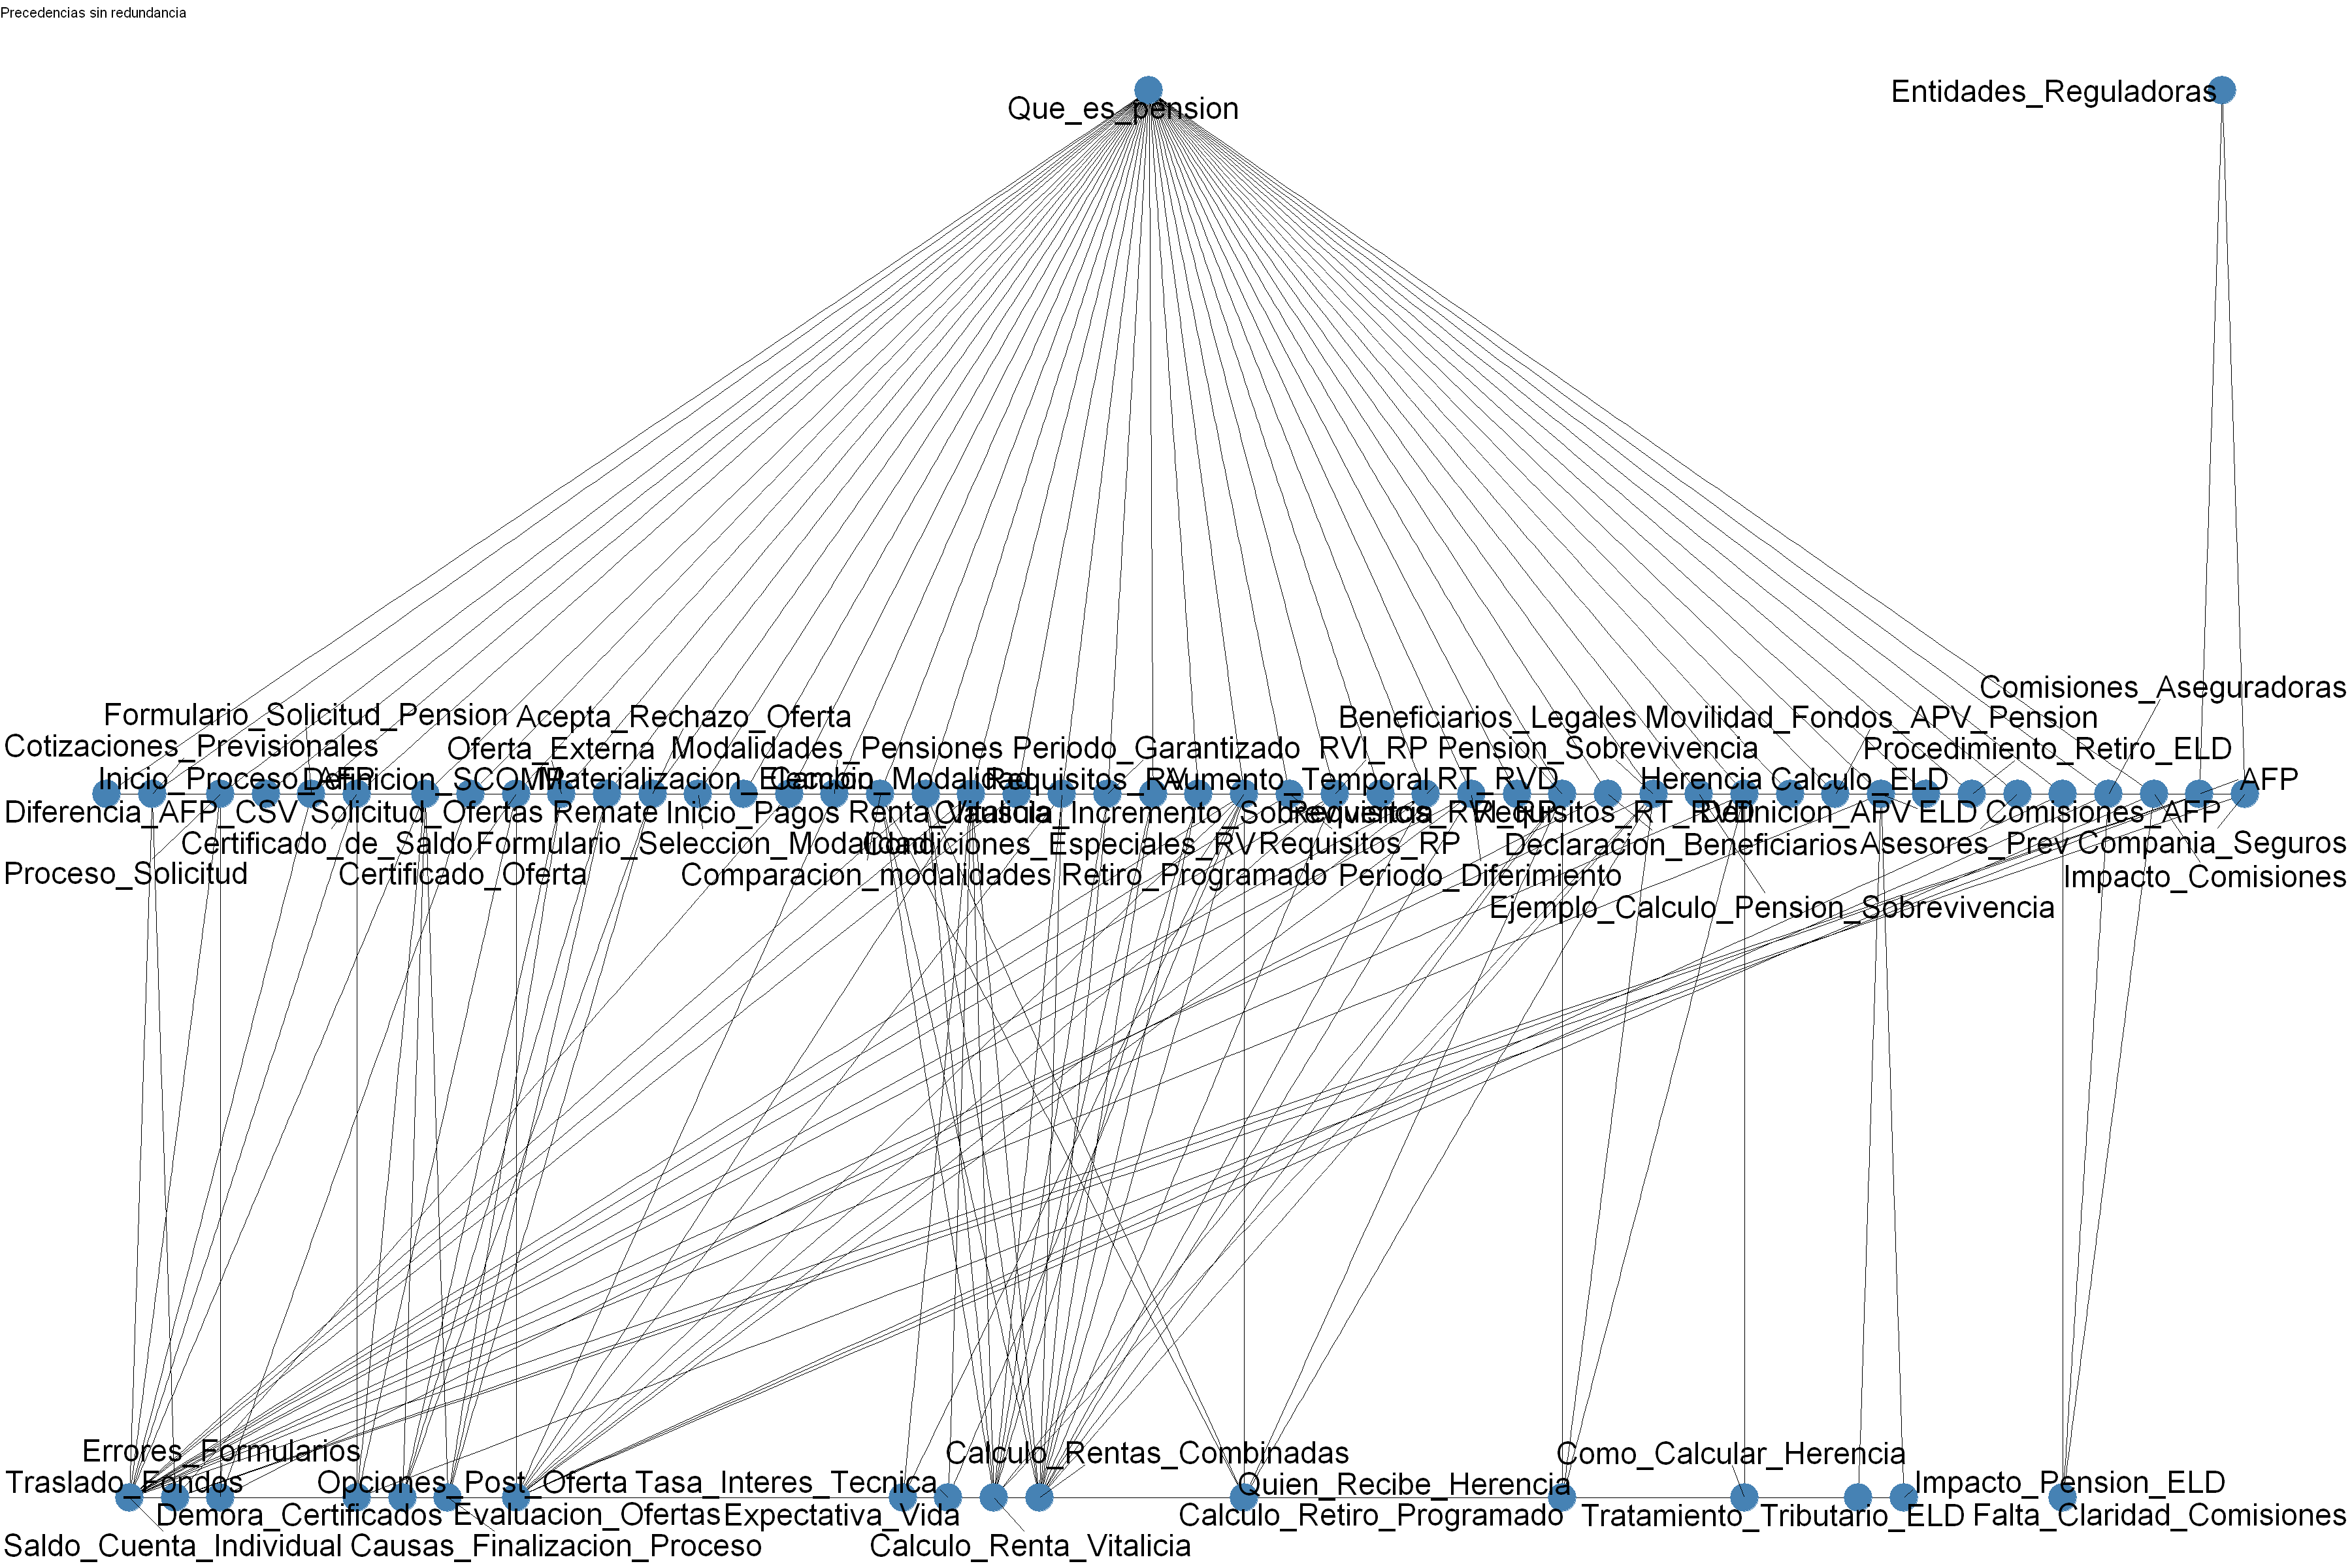

In [18]:
options(repr.plot.width = 30, repr.plot.height = 20)
# Convertir tu grafo igraph a tidygraph
grafo_tidy <- as_tbl_graph(g)

# Visualizar
ggraph(grafo_tidy, layout = "tree") +
  geom_edge_link(arrow = arrow(length = unit(1, 'mm')), end_cap = circle(2.5, 'mm')) +
  geom_node_point(size = 12, color = "steelblue") +
  geom_node_text(aes(label = name), repel = TRUE, size = 10, max.overlaps = Inf) +
  theme_void() +
  ggtitle("Precedencias sin redundancia")

In [20]:
eliminar_aristas_redundantes <- function(g) {
  aristas <- as_data_frame(g, what = "edges")
  redundantes <- c()

  for (i in seq_len(nrow(aristas))) {
    from <- aristas$from[i]
    to   <- aristas$to[i]
    
    # Eliminar temporalmente la arista
    g_temp <- delete_edges(g, E(g, P = c(from, to)))

    # Comprobar si existe otra ruta de from a to
    caminos <- suppressWarnings(all_simple_paths(g_temp, from = from, to = to))
    
    # Solo marcar como redundante si hay otro camino alternativo
    if (length(caminos) > 0) {
      redundantes <- c(redundantes, i)
    }
    cat(sprintf("Revisando %d de %d: %s → %s\n", i, nrow(aristas), from, to))
  flush.console()
  }

  # Eliminar aristas redundantes del grafo original
  g_sin <- delete_edges(g, E(g)[redundantes])
  return(g_sin)
}


In [ ]:
g_sin_redundancia <- eliminar_aristas_redundantes(g)


Revisando 1 de 375: Que_es_pension → Diferencia_AFP_CSV
Revisando 2 de 375: Que_es_pension → Cotizaciones_Previsionales
Revisando 3 de 375: Que_es_pension → Proceso_Solicitud
Revisando 4 de 375: Que_es_pension → Inicio_Proceso_AFP
Revisando 5 de 375: Que_es_pension → Formulario_Solicitud_Pension
Revisando 6 de 375: Que_es_pension → Certificado_de_Saldo
Revisando 7 de 375: Que_es_pension → Definicion_SCOMP
Revisando 8 de 375: Que_es_pension → Solicitud_Ofertas
Revisando 9 de 375: Que_es_pension → Certificado_Oferta
Revisando 10 de 375: Que_es_pension → Oferta_Externa
Revisando 11 de 375: Que_es_pension → Remate
Revisando 12 de 375: Que_es_pension → Acepta_Rechazo_Oferta
Revisando 13 de 375: Que_es_pension → Formulario_Seleccion_Modalidad
Revisando 14 de 375: Que_es_pension → Materializacion_Eleccion
Revisando 15 de 375: Que_es_pension → Inicio_Pagos
Revisando 16 de 375: Que_es_pension → Modalidades_Pensiones
Revisando 17 de 375: Que_es_pension → Comparacion_modalidades
Revisando 18 de 3

In [22]:
matriz_sin_redundancia <- as_adjacency_matrix(g_sin_redundancia, sparse = FALSE)

In [24]:
# Crea un grafo dirigido a partir de la matriz de adyacencia sin redundancias.

# - matriz_sin_redundancia: matriz binaria donde [i, j] = 1 indica que el nodo i precede al nodo j.
# - mode = "directed": conserva la dirección de las aristas (es decir, i → j ≠ j → i).
# - diag = FALSE: evita crear bucles (aristas de un nodo a sí mismo).

# Resultado:
# `g_sin_redundancia` es un objeto de clase `igraph` que representa 
# el grafo limpio, conservando solo las dependencias de primer orden.


g_sin_redundancia <- graph_from_adjacency_matrix(
  matriz_sin_redundancia,
  mode = "directed",
  diag = FALSE
)

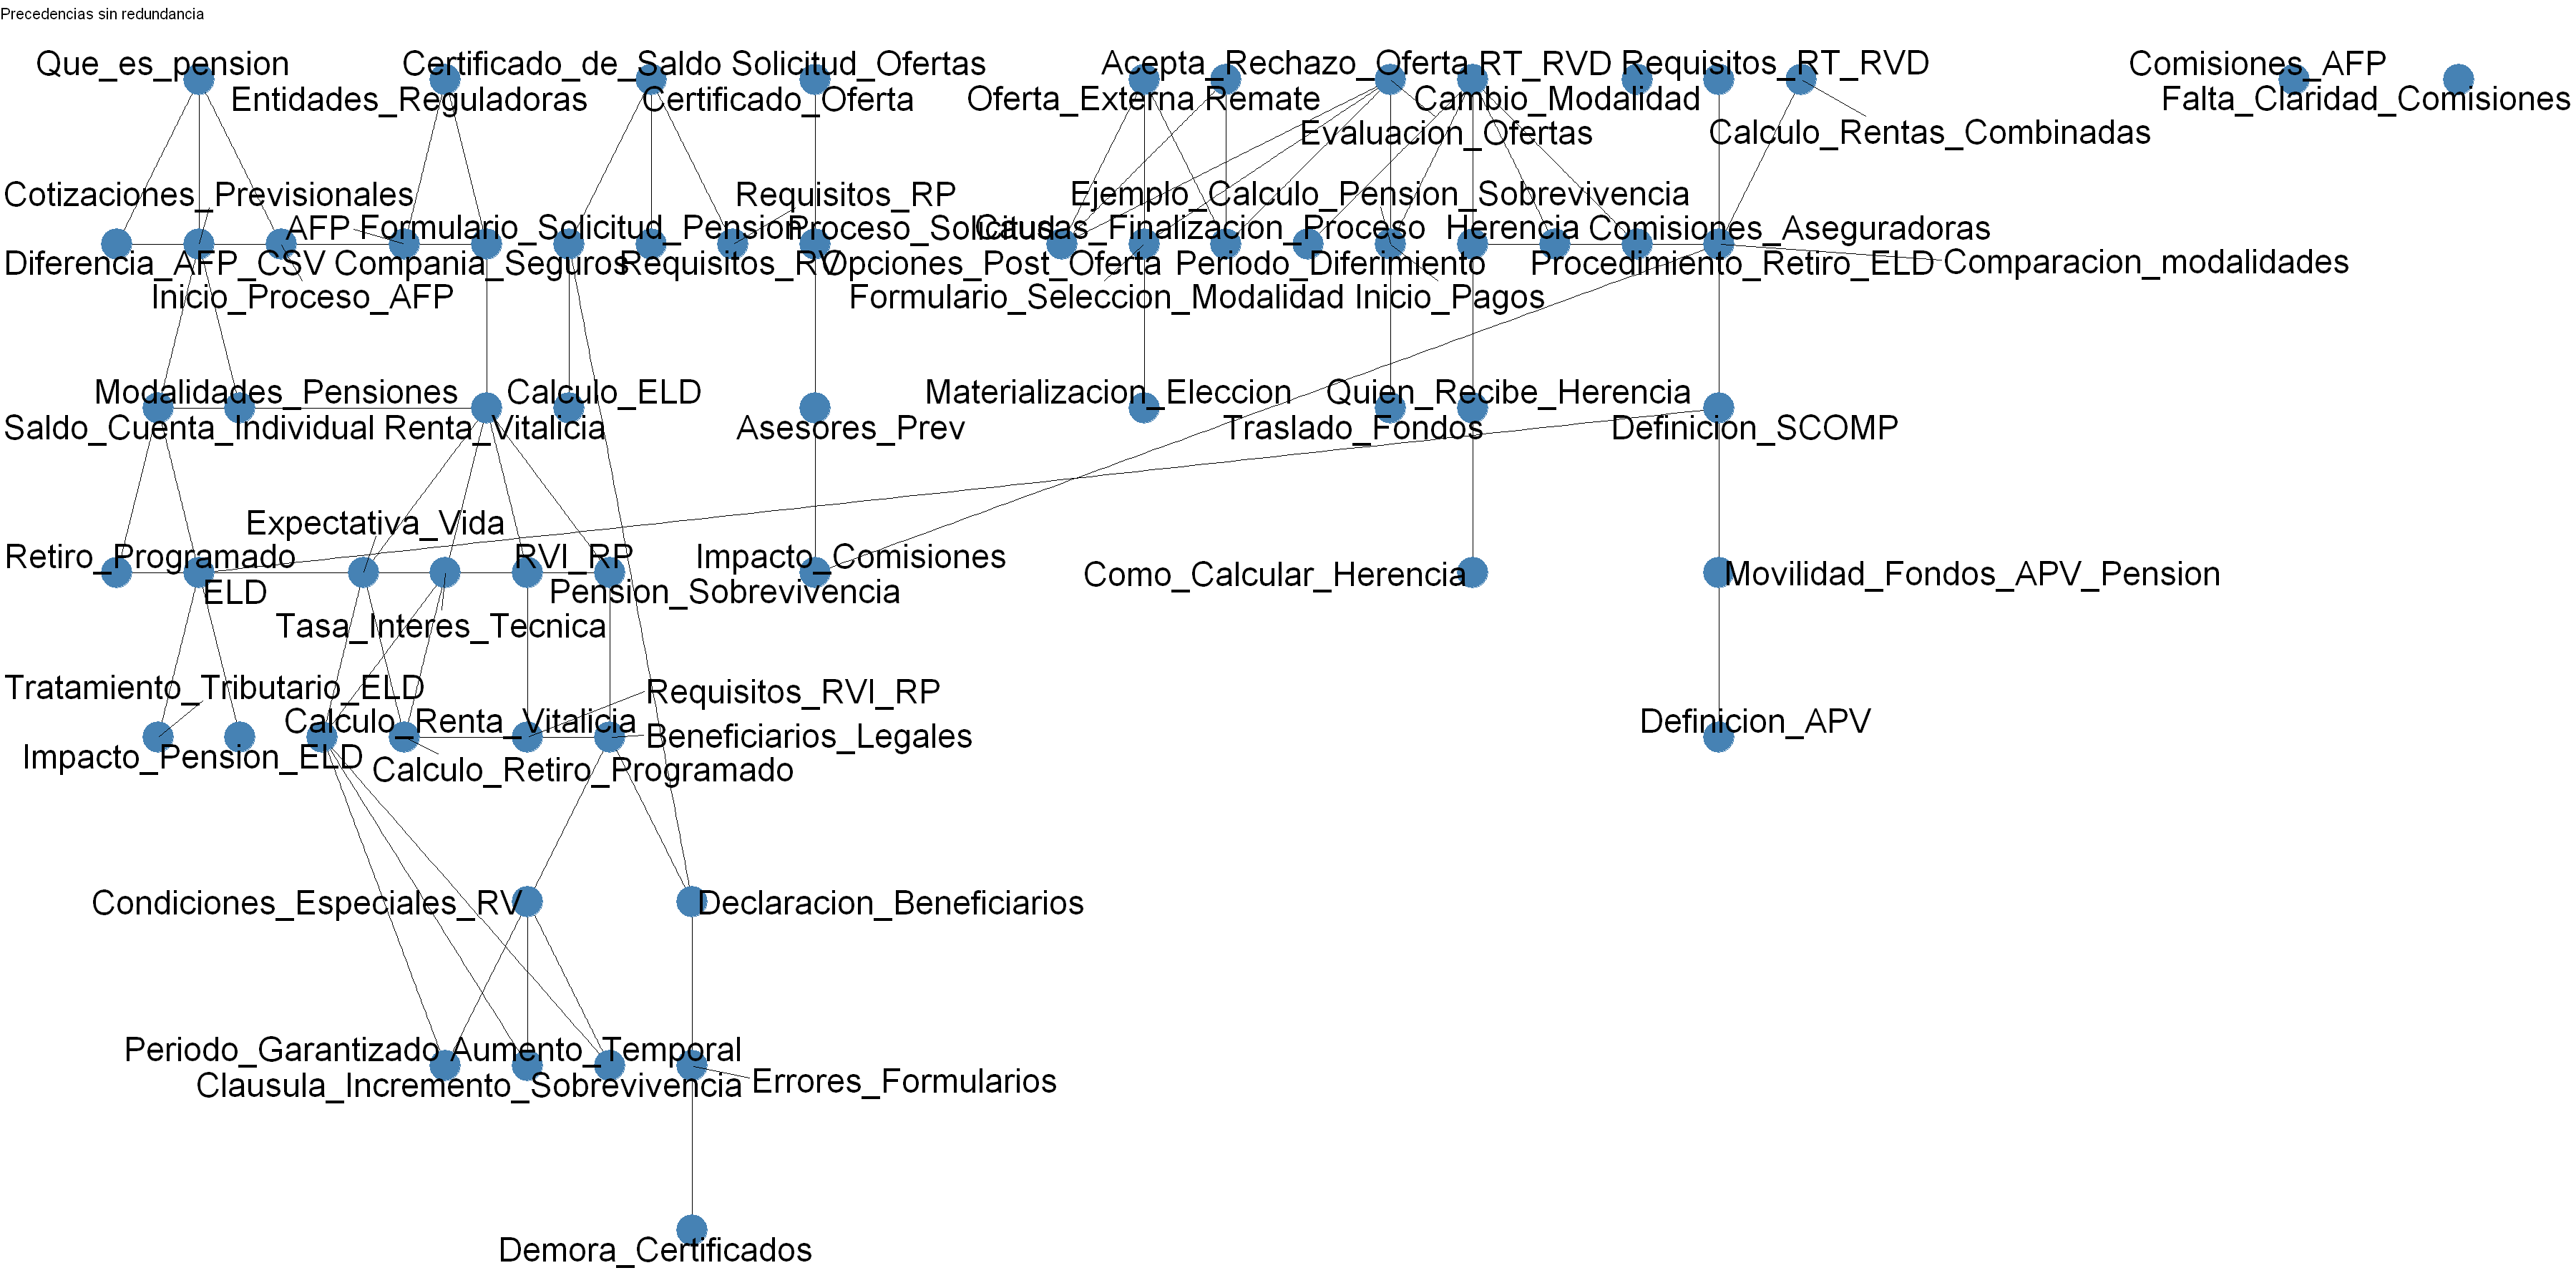

In [25]:
options(repr.plot.width = 30, repr.plot.height = 15)
# Convertir tu grafo igraph a tidygraph
grafo_tidy <- as_tbl_graph(g_sin_redundancia)

# Visualizar
ggraph(grafo_tidy, layout = "tree") +
  geom_edge_link(arrow = arrow(length = unit(1, 'mm')), end_cap = circle(2.5, 'mm')) +
  geom_node_point(size = 12, color = "steelblue") +
  geom_node_text(aes(label = name), repel = TRUE, size = 10, max.overlaps = Inf) +
  theme_void() +
  ggtitle("Precedencias sin redundancia")

In [26]:
# Convertimos a data.frame y agregamos la columna con los nombres de fila
df_matriz <- as.data.frame(matriz_sin_redundancia)
df_matriz <- tibble::rownames_to_column(df_matriz, var = "Concepto")
write_xlsx(df_matriz, path = "matriz_sin_redundancia.xlsx")


In [27]:
ggsave(
  filename = "grafo_precedencias.png",
  width = 30,
  height = 15,
  dpi = 300  # alta resolución
)
